This notebook will test the Super GAN framework's effectiveness at generating synthetic heart rate data. Specifically, we will generate data for each class in the PTB Diagnostic ECG Dataset, and then we will train a classifier on the synthetic data and test it on the real data (TSTR) to evaluate the realism of the synthetic dataset.

More information on the dataset is available at the following links:
- https://www.physionet.org/physiobank/database/ptbdb/
- https://www.kaggle.com/shayanfazeli/heartbeat/

For more information regarding this GAN framework, please see the following works:
- R. Saeedi, S. Norgaard and A.H. Gebremedhin, A Closed-loop Deep Learning Architecture for Robust Activity Recognition using Wearable Sensors, 2017 IEEE International Conference on Big Data (BigData 2017).
- S. Norgaard, R. Saeedi, K. Sasani, and A.H. Gebremedhin, Synthetic Sensor Data Generation for Health Applications: A Supervised Deep Learning Approach, IEEE Engineering in Medicine and Biology Society Conference (EMBC 2018).

BEST RESULTS SO FAR (72%):
- NUM_CLASSIFIER_EPOCHS = 10
- NUM_GAN_EPOCHS = 25
- CLASSIFIER_TRAIN_RATIO = 0.8
- NUM_SYNTHETIC_SAMPLES = 5000 # Per class

Author: Nathaniel M. Burley

In [1]:
# Imports 
import numpy as np
import pandas as pd
import tensorflow as tf
import training_module as train
import input_module as input_mod
import saving_module as save
from keras.models import Model, load_model, Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Lambda, Conv1D, MaxPooling1D
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from random import shuffle
import models, sys, h5py, keras
import matplotlib.pyplot as plt

# Global variables/constants defined
CLASS0_DATAFILE = "/Users/nmb1331/Downloads/heartbeat/ptbdb_normal.csv"
CLASS1_DATAFILE = "/Users/nmb1331/Downloads/heartbeat/ptbdb_abnormal.csv"

# Global variables for training
NUM_CLASSES = 2
NUM_CLASSIFIER_EPOCHS = 12
NUM_TSTR_CLASSIFIER_EPOCHS = 20
NUM_GAN_EPOCHS = 40 # Formerly 25. Curious if RTS or SFD is more important
CLASSIFIER_TRAIN_RATIO = 0.8
NUM_SYNTHETIC_SAMPLES = 8000 # Per class
NUM_STATS = 9 # Number of statistics computed for loss function. Do NOT change

# PARAMETERS RELATED TO TRAINING
latent_dim = 70 #length of random input fed to generator (should it be num_classes + 1?)
epochs = 100 #num training epochs
batch_size = 30 #num instances generated for G/D training
test_size = 100 #num instances generated for validating data
real_synthetic_ratio = 5 #num synthetic instances per real instance for computing RTS metric
synthetic_synthetic_ratio = 10 #num synthetic instances to compare for computing STS metric
disc_lr = .08 #learning rate of discriminator
accuracy_threshold = 0.95 #threshold to stop generator training

# WEIGHTS FOR DIFFERENT TERMS IN THE LOSS FUNCTION
D_loss_weight = 1.25
C_loss_weight = 0.75
SFD_loss_weight = 1

Using TensorFlow backend.


To begin with, we will read in the CSV files to Pandas dataframes, and assign columns. Since they are not labeled in the file, we will assign them integer labels. We'll begin by exploring the data, and making some plots, which will be compared to plots of the synthetic dataset. There is one file per class in this dataset, so after we read them in we will have to blend them to form training and testing sets:

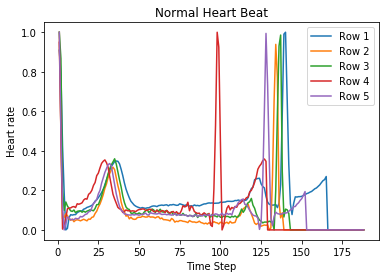

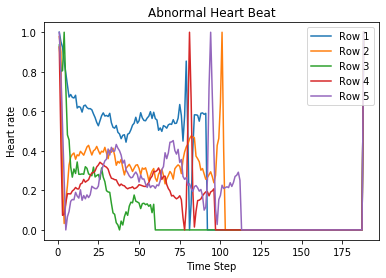

In [2]:
# Read in the data for class 0 (normal heartbeats); make datasets for this class (used in GAN)
hr_class0_raw = pd.read_csv(CLASS0_DATAFILE)
hr_class0_raw.columns = [i for i in range(1, len(hr_class0_raw.columns)+1)]
X_0 = hr_class0_raw
hr_class0_raw = hr_class0_raw.drop(labels=len(hr_class0_raw.columns), axis=1)

# Make plots of 4 rows for normal heartbeats (enter different values to see more plots)
for i in range(1, 6):
    plt.plot(X_0.columns, X_0.iloc[i], label="Row {}".format(i))
plt.xlabel('Time Step')
plt.ylabel('Heart rate')
plt.title('Normal Heart Beat')
plt.gca().legend(loc="upper right")
plt.show()

# Read in the data for class 1 (abnormal heartbeat); make datasets for this class (used in GAN)
hr_class1_raw = pd.read_csv(CLASS1_DATAFILE)
hr_class1_raw.columns = [i for i in range(1, len(hr_class1_raw.columns)+1)]
X_1 = hr_class1_raw
hr_class1_raw = hr_class1_raw.drop(labels=len(hr_class1_raw.columns), axis=1)

# Make plots of 4 rows for abnormal heartbeats (enter different values to see more plots)
for i in range(1, 6):
    plt.plot(X_1.columns, X_1.iloc[i], label="Row {}".format(i))
    plt.xlabel
plt.xlabel('Time Step')
plt.ylabel('Heart rate')
plt.title('Abnormal Heart Beat')
plt.gca().legend(loc="upper right")
plt.show()

# Close pyplot forcuz to save memory
plt.close()

In [3]:
# Read in the data for class 0 (normal heartbeat); make datasets for this class (used in GAN)
Y_0_raw = X_0[(len(X_0.columns))].values.T
#Y_0 = keras.utils.np_utils.to_categorical(Y_0_raw)
X_0 = X_0.drop(labels=len(X_0.columns), axis=1)
X_0 = X_0.values
X_0 = normalize(X_0)
X_0 = X_0.reshape((X_0.shape[0], X_0.shape[1], 1))
print("X_0 shape: {}".format(X_0.shape))
print("Y_0_raw shape: {}".format(Y_0_raw.shape))

# Read in the data for class 1 (abnormal heartbeat); make datasets for this class (used in GAN)
Y_1_raw = X_1[(len(X_1.columns))].values.T
#Y_1 = keras.utils.np_utils.to_categorical(Y_1_raw)
X_1 = X_1.drop(labels=len(X_1.columns), axis=1)
X_1 = X_1.values
X_1 = normalize(X_1)
X_1 = X_1.reshape((X_1.shape[0], X_1.shape[1], 1))
print("X_1 shape: {}".format(X_1.shape))
print("Y_1_raw shape: {}".format(Y_1_raw.shape))

# Build an X for the WHOLE dataset
X = np.concatenate((X_0, X_1))
Y = np.concatenate((Y_0_raw, Y_1_raw))
Y = keras.utils.np_utils.to_categorical(Y)
print("X shape: {}".format(X.shape))
print("Y shape: {}".format(Y.shape))

# Build training and testing sets (used in classifier)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, \
    train_size=CLASSIFIER_TRAIN_RATIO, shuffle=True)
print("Train X shape: {}".format(train_X.shape))
print("Train Y shape: {}".format(train_Y.shape))
print("Test X shape: {}".format(test_X.shape))
print("Test Y shape: {}".format(test_Y.shape))


X_0 shape: (4045, 187, 1)
Y_0_raw shape: (4045,)
X_1 shape: (10505, 187, 1)
Y_1_raw shape: (10505,)
X shape: (14550, 187, 1)
Y shape: (14550, 2)
Train X shape: (11640, 187, 1)
Train Y shape: (11640, 2)
Test X shape: (2910, 187, 1)
Test Y shape: (2910, 2)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Now that we have the data processed into training and testing sets, we will train a classifier on the data, which will be utilized in the GAN training process, per Saeedi et. all. Once the classifier is trained to 98% accuracy or so, we will save it:

In [4]:
# Parameters for training shape
num_seqs = X.shape[0]
seq_length = X.shape[1]
num_channels = X.shape[2]
input_shape = (seq_length, num_channels)

# Function that creates our classifier
def createClassifier(input_shape):
    classifier = Sequential(name="classifier")
    classifier.add(Conv1D(filters=128, kernel_size=(5), padding="same", input_shape=input_shape))
    classifier.add(MaxPooling1D(pool_size=(2)))
    classifier.add(Conv1D(filters=96, use_bias="true", kernel_size=(5), padding="same", activation="relu"))
    classifier.add(Conv1D(filters=64, kernel_size=(5), padding="same", activation="relu"))
    classifier.add(Conv1D(filters=48, kernel_size=(5), padding="same", activation="relu"))
    classifier.add(MaxPooling1D(pool_size=(2)))
    classifier.add(Conv1D(filters=32, kernel_size=(5), padding="same", activation='relu'))
    classifier.add(MaxPooling1D(pool_size=(2)))
    #classifer.add(Reshape(15, num_channels * 32))
    classifier.add(Dropout(0.5))
    classifier.add(LSTM(128, return_sequences=True,activation="tanh"))
    classifier.add(Dropout(0.5))
    classifier.add(LSTM(128, activation="tanh"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(NUM_CLASSES, activation="softmax"))

    # Training parameters
    classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    classifier.summary()
    return classifier

# Classifier trained here!
model = createClassifier(input_shape)
results = model.fit(train_X, train_Y, validation_data=(test_X, test_Y),\
        epochs=NUM_CLASSIFIER_EPOCHS, batch_size = 64, shuffle=True)


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 187, 128)          768       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 93, 96)            61536     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 64)            30784     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 93, 48)            15408     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 46, 48)            0         
___________________________________________________________

Awesome. Now that we have the classifier trained, we'll move on to training the GAN. Let's build the models used for training:

In [5]:
# CREATE GENERATOR AND DISCRIMINATOR
C = model # Classifier we trained earlier (To show, #print(C.summary()) )
C.name = "C"
# Generator/discriminator for class 0
G_0 = models.create_G(seq_length, num_channels, latent_dim)
D_0 = models.create_D(seq_length, num_channels)
D_to_freeze_0 = D_0
D_model_0 = models.compile_discriminator_model(D_0, disc_lr)
# Generator/discriminator for class 0
G_1 = models.create_G(seq_length, num_channels, latent_dim)
D_1 = models.create_D(seq_length, num_channels)
D_to_freeze_1 = D_1
D_model_1 = models.compile_discriminator_model(D_1, disc_lr)

# CREATE STATISTICAL FEATURE NETWORK AND COMPUTE FEATURE VECTOR FOR REAL DATA (used in loss function)
feature_net_0 = models.create_statistical_feature_net(seq_length, num_channels)
S_X_train_0 = np.repeat(np.reshape(np.mean(feature_net_0.predict(X, batch_size), axis=0), \
                                 (1, num_channels*NUM_STATS)), batch_size, axis=0)  
S_X_test_0 = np.repeat(np.reshape(np.mean(feature_net_0.predict(X, batch_size), axis=0), \
                                (1, num_channels*NUM_STATS)), test_size, axis=0)
# DO THE SAME FOR CLASS ONE
feature_net_1 = models.create_statistical_feature_net(seq_length, num_channels)
S_X_train_1 = np.repeat(np.reshape(np.mean(feature_net_1.predict(X, batch_size), axis=0), \
                                 (1, num_channels*NUM_STATS)), batch_size, axis=0)  
S_X_test_1 = np.repeat(np.reshape(np.mean(feature_net_1.predict(X, batch_size), axis=0), \
                                (1, num_channels*NUM_STATS)), test_size, axis=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 187, 1)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
dropou

Having built the models, we will now train the GAN, first for Class 0:

In [6]:
# SET CLASS LABEL TO ZERO
class_label = 0

#CREATE FULL ARCHITECTURE WHERE OUPUT OF GENERATOR IS FED TO DISCRIMINATOR AND CLASSIFIER
for layer in D_to_freeze_0.layers:
    layer.trainable = False
GCD = Model(inputs=G_0.input, outputs=[D_to_freeze_0(G_0.output), C(G_0.output), feature_net_0(G_0.output)])
GCD.compile(loss={"D":"binary_crossentropy","C":"binary_crossentropy","SFN": train.euc_dist_loss},\
            optimizer="adam", metrics={"D":"accuracy",'C':"accuracy"},\
            loss_weights = {"D": D_loss_weight, "C": C_loss_weight,"SFN": SFD_loss_weight})


GC_acc=0
epoch=1

while GC_acc<accuracy_threshold or epoch <= NUM_GAN_EPOCHS:
    print("Epoch: " + str(epoch))

    #TRAIN DISCRIMINATOR AND GENERATOR AND DISPLAY ACCURACY FOR EACH
    D_loss_vec = train.train_D(batch_size, X_0, G_0, D_model_0, latent_dim)
    GCD_loss_vec = train.train_G(batch_size, X_0, class_label, S_X_train_0, NUM_CLASSES, GCD, latent_dim)
    D_acc = D_loss_vec[1] #accuracy for discriminator during its "turn" for training
    GD_acc = GCD_loss_vec[4] #accuracy for generator in tricking discriminator
    print("D Acc: " + str(D_acc))
    print("G Acc in tricking D: " + str(GD_acc))

    #GENERATE SYNTHETIC DATA AND FEED TO CLASSIFIER TO DETERMINE ACCURACY
    synthetic_data = train.generate_synthetic_data(test_size, G_0, latent_dim, seq_length)
    pred = C.predict_classes(synthetic_data,test_size,verbose=0)
    true = [class_label]*test_size
    GC_acc = accuracy_score(true, pred)
    print("C acc for synthetic data: " + str(GC_acc))

    #COMPUTE RTS AND STS METRICS
    mean_RTS_sim, mean_STS_sim, _ = train.compute_similarity_metrics(synthetic_data, X_0, test_size,\
    real_synthetic_ratio, synthetic_synthetic_ratio)
    print("RTS similarity: " + str(mean_RTS_sim))
    print("STS similarity: " + str(mean_STS_sim))

    #COMPUTE STATISTICAL FEATURE DISTANCE
    synthetic_features = feature_net_0.predict(synthetic_data, test_size, verbose=0)
    SFD = train.compute_SFD(synthetic_features, S_X_test_0)
    print("SFD: " + str(SFD) + "\n")

    epoch+=1
    one_segment_real = np.reshape(X_0[np.random.randint(0, X_0.shape[0], 1)], (seq_length, num_channels))

Epoch: 1


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 1.0
RTS similarity: 0.6748286689676506
STS similarity: 0.99703634
SFD: 5.1672573

Epoch: 2


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 1.0
RTS similarity: 0.6593537647760853
STS similarity: 0.9966027
SFD: 4.455717

Epoch: 3


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 1.0
RTS similarity: 0.6670108094632297
STS similarity: 0.99635494
SFD: 3.7679617

Epoch: 4


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 1.0
RTS similarity: 0.6696490384952336
STS similarity: 0.99634
SFD: 3.1130457

Epoch: 5


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 1.0
RTS similarity: 0.6772777598292237
STS similarity: 0.9963646
SFD: 2.5362515

Epoch: 6


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 1.0
RTS similarity: 0.6934564174530945
STS similarity: 0.9960853
SFD: 1.9821141

Epoch: 7


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 1.0
RTS similarity: 0.703173170441098
STS similarity: 0.99629605
SFD: 1.4947034

Epoch: 8


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 1.0
RTS similarity: 0.7051804843572479
STS similarity: 0.9966196
SFD: 1.0599694

Epoch: 9


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 0.0
RTS similarity: 0.7124806394198722
STS similarity: 0.9970083
SFD: 0.68894404

Epoch: 10


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.0
C acc for synthetic data: 0.0
RTS similarity: 0.7217823810381906
STS similarity: 0.99670047
SFD: 0.4010909

Epoch: 11


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.033333335
C acc for synthetic data: 0.0
RTS similarity: 0.7289294794984525
STS similarity: 0.9968525
SFD: 0.30335835

Epoch: 12


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.06666667
C acc for synthetic data: 0.0
RTS similarity: 0.7267875197739044
STS similarity: 0.9967084
SFD: 0.23002957

Epoch: 13


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.2
C acc for synthetic data: 0.0
RTS similarity: 0.7310986213485466
STS similarity: 0.9964773
SFD: 0.1663479

Epoch: 14


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.16666667
C acc for synthetic data: 0.0
RTS similarity: 0.7349054510143006
STS similarity: 0.9962603
SFD: 0.12545916

Epoch: 15


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.43333334
G Acc in tricking D: 0.26666668
C acc for synthetic data: 0.0
RTS similarity: 0.7374517976069697
STS similarity: 0.99694234
SFD: 0.12836578

Epoch: 16


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.21666667
G Acc in tricking D: 0.46666667
C acc for synthetic data: 0.0
RTS similarity: 0.7362419228336041
STS similarity: 0.9969963
SFD: 0.17008087

Epoch: 17


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.25
G Acc in tricking D: 0.4
C acc for synthetic data: 0.09
RTS similarity: 0.7366109438723492
STS similarity: 0.9969449
SFD: 0.2233992

Epoch: 18


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.31666666
G Acc in tricking D: 0.5
C acc for synthetic data: 0.94
RTS similarity: 0.7342325993727883
STS similarity: 0.9967821
SFD: 0.2758811

Epoch: 19


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.25
G Acc in tricking D: 0.73333335
C acc for synthetic data: 1.0
RTS similarity: 0.7308648612842065
STS similarity: 0.99695826
SFD: 0.31950027

Epoch: 20


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.31666666
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7302171250678641
STS similarity: 0.9968712
SFD: 0.35395205

Epoch: 21


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.0
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7285292187799464
STS similarity: 0.99720097
SFD: 0.37917876

Epoch: 22


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7218182204548795
STS similarity: 0.9969616
SFD: 0.39904284

Epoch: 23


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7171069034866959
STS similarity: 0.9974102
SFD: 0.41356063

Epoch: 24


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7165514776074546
STS similarity: 0.99677193
SFD: 0.42309815

Epoch: 25


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.720291259432223
STS similarity: 0.9976385
SFD: 0.42702487

Epoch: 26


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7183601607843202
STS similarity: 0.9972431
SFD: 0.42817658

Epoch: 27


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7225507987694746
STS similarity: 0.99740887
SFD: 0.42680117

Epoch: 28


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7187208960679057
STS similarity: 0.99684554
SFD: 0.42105046

Epoch: 29


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7212680340960688
STS similarity: 0.9970273
SFD: 0.41368526

Epoch: 30


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.723395937084726
STS similarity: 0.99703723
SFD: 0.40281522

Epoch: 31


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7251816098278477
STS similarity: 0.99645483
SFD: 0.38856098

Epoch: 32


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7286508838584846
STS similarity: 0.9964223
SFD: 0.37276652

Epoch: 33


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7294691122937739
STS similarity: 0.9964676
SFD: 0.35313243

Epoch: 34


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7322490088161095
STS similarity: 0.9966351
SFD: 0.33261383

Epoch: 35


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7359078337811034
STS similarity: 0.9957779
SFD: 0.31072018

Epoch: 36


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7346470626525928
STS similarity: 0.996215
SFD: 0.28655714

Epoch: 37


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7328386453264384
STS similarity: 0.9957549
SFD: 0.26429796

Epoch: 38


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7357925865557736
STS similarity: 0.9961971
SFD: 0.24253152

Epoch: 39


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7348884545007753
STS similarity: 0.9955904
SFD: 0.22483395

Epoch: 40


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7316356976576236
STS similarity: 0.99575007
SFD: 0.21356317



Next, we'll train a GAN to generate data for Class 1:

In [7]:
# SET CLASS LABEL TO ONE
class_label = 1

#CREATE FULL ARCHITECTURE WHERE OUPUT OF GENERATOR IS FED TO DISCRIMINATOR AND CLASSIFIER
for layer in D_to_freeze_1.layers:
    layer.trainable = False
GCD = Model(inputs=G_1.input, outputs=[D_to_freeze_1(G_1.output), C(G_1.output), feature_net_1(G_1.output)])
GCD.compile(loss={"D":"binary_crossentropy","C":"binary_crossentropy","SFN": train.euc_dist_loss},\
            optimizer="adam", metrics={"D":"accuracy",'C':"accuracy"},\
            loss_weights = {"D": D_loss_weight, "C": C_loss_weight,"SFN": SFD_loss_weight})


GC_acc=0
epoch=1

while GC_acc<accuracy_threshold or epoch <= NUM_GAN_EPOCHS:
    print("Epoch: " + str(epoch))

    #TRAIN DISCRIMINATOR AND GENERATOR AND DISPLAY ACCURACY FOR EACH
    D_loss_vec = train.train_D(batch_size, X_1, G_1, D_model_1, latent_dim)
    GCD_loss_vec = train.train_G(batch_size, X_1, class_label, S_X_train_1, NUM_CLASSES, GCD, latent_dim)
    D_acc = D_loss_vec[1] #accuracy for discriminator during its "turn" for training
    GD_acc = GCD_loss_vec[4] #accuracy for generator in tricking discriminator
    print("D Acc: " + str(D_acc))
    print("G Acc in tricking D: " + str(GD_acc))

    #GENERATE SYNTHETIC DATA AND FEED TO CLASSIFIER TO DETERMINE ACCURACY
    synthetic_data = train.generate_synthetic_data(test_size, G_1, latent_dim, seq_length)
    pred = C.predict_classes(synthetic_data,test_size,verbose=0)
    true = [class_label]*test_size
    GC_acc = accuracy_score(true, pred)
    print("C acc for synthetic data: " + str(GC_acc))

    #COMPUTE RTS AND STS METRICS
    mean_RTS_sim, mean_STS_sim, _ = train.compute_similarity_metrics(synthetic_data, X_1, test_size,\
    real_synthetic_ratio, synthetic_synthetic_ratio)
    print("RTS similarity: " + str(mean_RTS_sim))
    print("STS similarity: " + str(mean_STS_sim))

    #COMPUTE STATISTICAL FEATURE DISTANCE
    synthetic_features = feature_net_1.predict(synthetic_data, test_size, verbose=0)
    SFD = train.compute_SFD(synthetic_features, S_X_test_1)
    print("SFD: " + str(SFD) + "\n")

    epoch+=1
    one_segment_real = np.reshape(X_1[np.random.randint(0, X_1.shape[0], 1)], (seq_length, num_channels))

Epoch: 1


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6315085067160392
STS similarity: 0.9971839
SFD: 4.6926045

Epoch: 2


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6403323212661428
STS similarity: 0.99723446
SFD: 3.9741127

Epoch: 3


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6436248938422547
STS similarity: 0.99759275
SFD: 3.2946897

Epoch: 4


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6427185491656853
STS similarity: 0.997077
SFD: 2.6609893

Epoch: 5


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6495544682205994
STS similarity: 0.99732894
SFD: 2.0904799

Epoch: 6


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6656573691741636
STS similarity: 0.996916
SFD: 1.5798973

Epoch: 7


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6795368869334001
STS similarity: 0.99714243
SFD: 1.1378837

Epoch: 8


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6882474987498717
STS similarity: 0.99725276
SFD: 0.7566659

Epoch: 9


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6968467147264354
STS similarity: 0.99711496
SFD: 0.43851253

Epoch: 10


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.6969309823923011
STS similarity: 0.996926
SFD: 0.18559904

Epoch: 11


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7109263377132116
STS similarity: 0.997629
SFD: 0.109662466

Epoch: 12


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7107162416805317
STS similarity: 0.9978549
SFD: 0.24448377

Epoch: 13


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.7086541943966065
STS similarity: 0.9980718
SFD: 0.3621244

Epoch: 14


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.6944675133001547
STS similarity: 0.99826145
SFD: 0.44324926

Epoch: 15


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.6821075910028226
STS similarity: 0.9984514
SFD: 0.49788725

Epoch: 16


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.6573846881458539
STS similarity: 0.99865645
SFD: 0.53466725

Epoch: 17


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.6468081744458813
STS similarity: 0.99868643
SFD: 0.56171125

Epoch: 18


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.6327501499884908
STS similarity: 0.99874437
SFD: 0.57986975

Epoch: 19


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.618583953456387
STS similarity: 0.9990629
SFD: 0.5940769

Epoch: 20


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.6110239857285558
STS similarity: 0.99875736
SFD: 0.6039041

Epoch: 21


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.6061882268084334
STS similarity: 0.9991439
SFD: 0.6120417

Epoch: 22


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.6008163391502662
STS similarity: 0.99909943
SFD: 0.61859614

Epoch: 23


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.5941886348527633
STS similarity: 0.9989706
SFD: 0.62196845

Epoch: 24


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.93333334
C acc for synthetic data: 1.0
RTS similarity: 0.5924470051715557
STS similarity: 0.99899113
SFD: 0.6250521

Epoch: 25


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.7
C acc for synthetic data: 1.0
RTS similarity: 0.5877198255994961
STS similarity: 0.9986787
SFD: 0.62759566

Epoch: 26


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 0.7
C acc for synthetic data: 1.0
RTS similarity: 0.5929342001277522
STS similarity: 0.99880135
SFD: 0.6287742

Epoch: 27


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.56666666
G Acc in tricking D: 0.6333333
C acc for synthetic data: 1.0
RTS similarity: 0.5855462319591345
STS similarity: 0.99871606
SFD: 0.62934625

Epoch: 28


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.6666667
G Acc in tricking D: 0.4
C acc for synthetic data: 1.0
RTS similarity: 0.5878474271036335
STS similarity: 0.9988171
SFD: 0.62900597

Epoch: 29


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.68333334
G Acc in tricking D: 0.43333334
C acc for synthetic data: 1.0
RTS similarity: 0.591746283029844
STS similarity: 0.9983531
SFD: 0.6303026

Epoch: 30


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.78333336
G Acc in tricking D: 0.43333334
C acc for synthetic data: 1.0
RTS similarity: 0.5939612290380594
STS similarity: 0.9984172
SFD: 0.6265845

Epoch: 31


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.81666666
G Acc in tricking D: 0.2
C acc for synthetic data: 1.0
RTS similarity: 0.5979788645002787
STS similarity: 0.9980195
SFD: 0.6257734

Epoch: 32


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.85
G Acc in tricking D: 0.23333333
C acc for synthetic data: 1.0
RTS similarity: 0.6043717162920889
STS similarity: 0.9979552
SFD: 0.621665

Epoch: 33


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.9
G Acc in tricking D: 0.36666667
C acc for synthetic data: 1.0
RTS similarity: 0.6055890382969604
STS similarity: 0.9981106
SFD: 0.6201935

Epoch: 34


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.8666667
G Acc in tricking D: 0.13333334
C acc for synthetic data: 1.0
RTS similarity: 0.6098592664147158
STS similarity: 0.9978527
SFD: 0.6161721

Epoch: 35


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.96666664
G Acc in tricking D: 0.2
C acc for synthetic data: 1.0
RTS similarity: 0.6140495628679413
STS similarity: 0.99812776
SFD: 0.61050534

Epoch: 36


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.8
G Acc in tricking D: 0.13333334
C acc for synthetic data: 1.0
RTS similarity: 0.6158365048279147
STS similarity: 0.99743116
SFD: 0.6044064

Epoch: 37


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.8333333
G Acc in tricking D: 0.23333333
C acc for synthetic data: 1.0
RTS similarity: 0.6247199564298469
STS similarity: 0.9978076
SFD: 0.59962445

Epoch: 38


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.9166667
G Acc in tricking D: 0.033333335
C acc for synthetic data: 1.0
RTS similarity: 0.6331990229661676
STS similarity: 0.99762094
SFD: 0.5929998

Epoch: 39


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.8833333
G Acc in tricking D: 0.13333334
C acc for synthetic data: 1.0
RTS similarity: 0.6429005528874738
STS similarity: 0.99596345
SFD: 0.5845073

Epoch: 40


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.8833333
G Acc in tricking D: 0.23333333
C acc for synthetic data: 1.0
RTS similarity: 0.6478996747335798
STS similarity: 0.9967848
SFD: 0.5769772



Now that we've trained the GANs, we need to generate synthetic datasets with them:

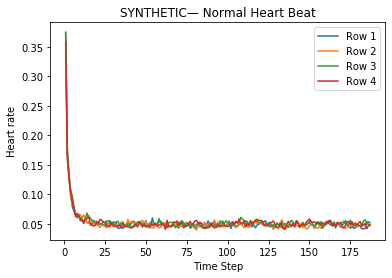

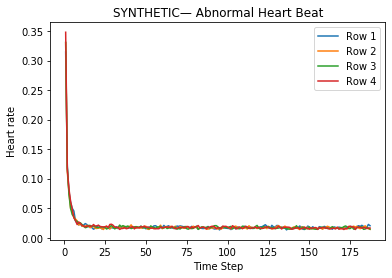

In [8]:
# Generate data for class 0
X_synthetic_0 = train.generate_synthetic_data(NUM_SYNTHETIC_SAMPLES, G_0, latent_dim, seq_length)
Y_synthetic_0 = np.zeros(NUM_SYNTHETIC_SAMPLES)

# Plot the synthetic data for class 1
synth_X0_plot = X_synthetic_0.reshape((NUM_SYNTHETIC_SAMPLES, seq_length))
for i in range(1, 5):
    plt.plot([x for x in range(1, seq_length+1)], synth_X0_plot[i], label="Row {}".format(i))
plt.xlabel('Time Step')
plt.ylabel('Heart rate')
plt.title('SYNTHETIC— Normal Heart Beat')
plt.gca().legend(loc="upper right")
plt.show()
    

# Generate data for class 1
X_synthetic_1 = train.generate_synthetic_data(NUM_SYNTHETIC_SAMPLES, G_1, latent_dim, seq_length)
Y_synthetic_1 = np.ones(NUM_SYNTHETIC_SAMPLES)

# Plot the synthetic data for class 1
synth_X1_plot = X_synthetic_1.reshape((NUM_SYNTHETIC_SAMPLES, seq_length))
for i in range(1, 5):
    plt.plot([x for x in range(1, seq_length+1)], synth_X1_plot[i], label="Row {}".format(i))
plt.xlabel('Time Step')
plt.ylabel('Heart rate')
plt.title('SYNTHETIC— Abnormal Heart Beat')
plt.gca().legend(loc="upper right")
plt.show()

plt.close()

Then, we will take this synthetic dataset, and train a classifier on it. We will then validate the classifier using the real data:

In [9]:
# Build the synthetic dataset (combine generated data from both classes)
X_synthetic = np.concatenate((X_synthetic_0, X_synthetic_1), axis=0)
print(X_synthetic.shape)
Y_synthetic = keras.utils.np_utils.to_categorical\
    (np.concatenate((Y_synthetic_0, Y_synthetic_1), axis=0))
print(Y_synthetic.shape)

# Classifier trained here!
tstr_model = createClassifier(input_shape)
tstr_results = tstr_model.fit(X_synthetic, Y_synthetic, validation_data=(test_X, test_Y),\
        epochs=NUM_TSTR_CLASSIFIER_EPOCHS, batch_size = 64, shuffle=True)

(16000, 187, 1)
(16000, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 187, 128)          768       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 93, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 93, 96)            61536     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 93, 64)            30784     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 93, 48)            15408     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 46, 48)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 46, 32)      